## Preparation

In [1]:
# !cat  /proc/cpuinfo

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f78e2aad-fe40-65b8-a972-5337f77cdd22)


In [3]:
%%capture
!pip install tensorly
!pip install --upgrade torch torchvision

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)
torch.manual_seed(0)

from trainer import train, test
from tucker_layer import TuckerLayer

1.10.1+cu102


In [5]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
train_data = torchvision.datasets.CIFAR10(root='./downloads/2013', train=True, download=True, transform=transform)
train_val_split = (int(len(train_data) * 0.8), len(train_data) - int(len(train_data) * 0.8))
train_data, val_data = torch.utils.data.random_split(train_data, train_val_split)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=False, num_workers=1)

test_data = torchvision.datasets.CIFAR10(root='./downloads/2013', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


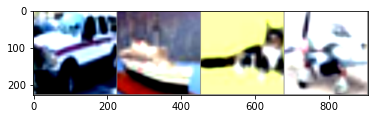

tensor(1) tensor(8) tensor(3) tensor(0)


In [7]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

## ALexNet

In [8]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
AlexNet_model.eval()
AlexNet_model.classifier[1] = nn.Linear(9216,4096)
AlexNet_model.classifier[4] = nn.Linear(4096,1024)
AlexNet_model.classifier[6] = nn.Linear(1024,10)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [9]:
# AlexNet_model = AlexNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
AlexNet_model.to(device)
def loss_func1(model, output, labels):
    return nn.CrossEntropyLoss()(output, labels)
optimizer1 = optim.SGD(
    [
        {"params": AlexNet_model.features.parameters(), "lr": 0.0001, "momentum": 0.9},
        {"params": AlexNet_model.classifier.parameters(), "lr": 0.001, "momentum": 0.9},
    ],
    lr=0.0001,
)
scheduler1 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer1, T_0=1, T_mult=2, verbose=False)

cuda:0


In [10]:
train(model=AlexNet_model,
      train_loader=trainloader,
      val_loader=valloader,
      epoch_num=63,
      optimizer=optimizer1,
      scheduler=scheduler1,
      scheduler_step='batch',
      loss_func=loss_func1,
      path='alexnet')

In [11]:
del(AlexNet_model)

## AlexNet Tucker Compression without orthogonal

In [12]:
AlexTucker_model = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=False)
AlexTucker_model.eval()
AlexTucker_model.classifier[1] = nn.Linear(9216,4096)
AlexTucker_model.classifier[4] = nn.Linear(4096,1024)
AlexTucker_model.classifier[6] = nn.Linear(1024,10)
AlexTucker_model.load_state_dict(torch.load('alexnet_best.pth'))
AlexTucker_model = AlexTucker_model.to('cpu')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [13]:
for i in [10]:
    AlexTucker_model.features[i] = TuckerLayer.from_Conv2D(AlexTucker_model.features[i], method='HOSVD')

Tucker Decompose with rank (67, 65)
/home/pai/lib/python3.6/site-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
AlexTucker_model.to(device)
optimizer2 = optim.SGD(
    [
        {"params": AlexTucker_model.features[10].parameters(), "lr": 0.0001, "momentum": 0.9},
    ],
    lr=0.00001, momentum=0.9
)
scheduler2 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer2, T_0=1, T_mult=2, verbose=False)

cuda:0


In [15]:
before_accu = test(AlexTucker_model, valloader)
print('Acuracy: {:.3f}'.format(before_accu * 100))

Acuracy: 88.810


In [16]:
train(model=AlexTucker_model,
      train_loader=trainloader,
      val_loader=valloader,
      epoch_num=63,
      optimizer=optimizer2,
      scheduler=scheduler2,
      scheduler_step='batch',
      loss_func=loss_func1,
      path='alexnet_tucker')

In [17]:
del(AlexTucker_model)

## AlexNet Tucker Compression with orthogonal regularization

In [18]:
AlexTucker_model = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=False)
AlexTucker_model.eval()
AlexTucker_model.classifier[1] = nn.Linear(9216,4096)
AlexTucker_model.classifier[4] = nn.Linear(4096,1024)
AlexTucker_model.classifier[6] = nn.Linear(1024,10)
AlexTucker_model.load_state_dict(torch.load('alexnet_best.pth'))
AlexTucker_model = AlexTucker_model.to('cpu')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [19]:
for i in [10]:
    AlexTucker_model.features[i] = TuckerLayer.from_Conv2D(AlexTucker_model.features[i], method='HOSVD')

Tucker Decompose with rank (67, 65)


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
AlexTucker_model.to(device)
def loss_func2(model, output, labels):
    loss1 = nn.CrossEntropyLoss()(output, labels)
    loss2 = 0.0
    for i in [10]:
        loss2 += model.features[i].orthogonal_error()
    return loss1 + 0.01 * loss2
optimizer3 = optim.SGD(
    [
        {"params": AlexTucker_model.features[10].parameters(), "lr": 0.0001, "momentum": 0.9},
    ],
    lr=0.00001, momentum=0.9
)
scheduler3 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer3, T_0=1, T_mult=2, verbose=False)

cuda:0


In [21]:
train(model=AlexTucker_model,
      train_loader=trainloader,
      val_loader=valloader,
      epoch_num=63,
      optimizer=optimizer3,
      scheduler=scheduler3,
      scheduler_step='batch',
      loss_func=loss_func2,
      path='alexnet_tucker2')

[17,  2000] loss: 0.027 Time: 22.671 22.671
[17,  4000] loss: 0.028 Time: 45.091 45.092
[17,  6000] loss: 0.023 Time: 67.548 67.548
[17,  8000] loss: 0.025 Time: 89.954 89.954
[17, 10000] loss: 0.028 Time: 112.392 112.392
Accuracy: 89.630
[18,  2000] loss: 0.023 Time: 22.590 156.911
[18,  4000] loss: 0.027 Time: 45.059 179.380
[18,  6000] loss: 0.024 Time: 67.546 201.867
[18,  8000] loss: 0.024 Time: 90.068 224.389
[18, 10000] loss: 0.027 Time: 112.508 246.828
Accuracy: 90.060
[19,  2000] loss: 0.018 Time: 22.609 291.408
[19,  4000] loss: 0.027 Time: 45.065 313.864
[19,  6000] loss: 0.018 Time: 67.533 336.332
[19,  8000] loss: 0.021 Time: 89.972 358.771
[19, 10000] loss: 0.017 Time: 112.449 381.248
Accuracy: 89.740
[20,  2000] loss: 0.020 Time: 22.652 425.706
[20,  4000] loss: 0.024 Time: 45.112 448.166
[20,  6000] loss: 0.019 Time: 67.723 470.777
[20,  8000] loss: 0.016 Time: 90.236 493.289
[20, 10000] loss: 0.021 Time: 112.686 515.740
Accuracy: 89.970
[21,  2000] loss: 0.020 Time: 22

In [22]:
del(AlexTucker_model)

In [23]:
def count_parameters(paras):
    return sum(p.numel() for p in paras if p.requires_grad)

def test_model_from_path(model_path):
    model = torch.jit.load(model_path + '.pt')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    start_time = time.time()
    print(count_parameters(model.parameters()))
    print(count_parameters(model.features.parameters()))
    print('{:.3f}'.format(test(model, testloader) * 100))
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    print(time.time() - start_time)

In [ ]:
test_model_from_path('alexnet')
test_model_from_path('alexnet_tucker')
test_model_from_path('alexnet_tucker2')
print(before_accu)

44428106
2469696
90.800
21.31387948989868
43911269
1952859
